# Определение возраста покупателей

## Исследовательский анализ данных

**Цель проекта**
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Требуется построить модель, которая по фотографии определит приблизительный возраст человека.

**Ход выполнения** 

1. Исследовательский анализ набора фотографий.
2. Подготовка данных к обучению.
3. Обучение нейронной сети и рассчет её качества.

**Описание данных**

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
except:
    labels = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv')

In [50]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В датафрейме 7591 изображений.

In [51]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Text(0, 0.5, 'количество')

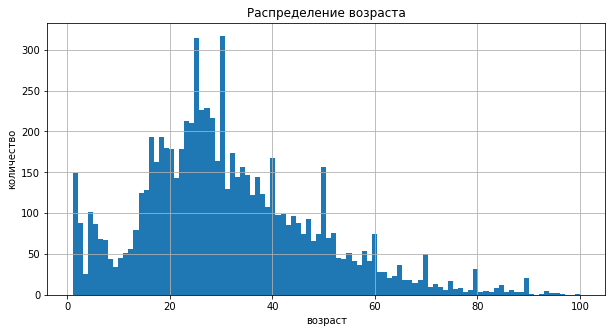

In [3]:
labels.hist(figsize=(10,5), bins=100, grid=True)
plt.title('Распределение возраста')
plt.xlabel('возраст')
plt.ylabel('количество')

Данная выборка содержит фотографии людей разных воздрастов. Наиболее часто встречаются люди 21-30 лет, 50% данных составляют люди 20-41 года, средний возраст равен 31,2. Виден хвост редких значений старше 70, в целом данные нормально распределены.

В данных видны пики в круглые даты, вероятно это связано с тем, что возраст присвоен по фотографии приблизительно.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [7]:
features, target = next(train_datagen_flow)

Получили признаки — четырёхмерный тензор, в котором 32 изображения размером 224x224 с тремя цветовыми каналами.

In [ ]:
features.shape

Ниже рассмотрим распределение возрастов в выборке.

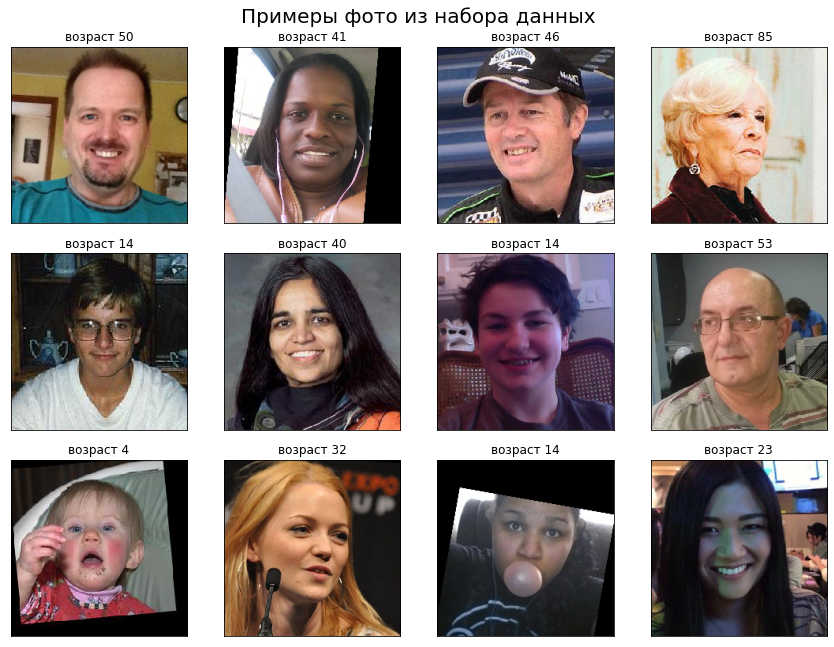

In [15]:
fig = plt.figure(figsize=(12,12))
plt.suptitle('Примеры фото из набора данных', fontsize=20)
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'возраст {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Как можно заметить, в выборке есть и цветные изображения, и черно-белые. Встречаются размытые изображения, обрезанные, в профиль и анфас.

**ВЫВОД** 

Итак, набор данных содержит 7591 цветную фотографию размером 224x224. Для определения возраста по фото можно использовать архитектуру *ResNet* без заморозки основного слоя. Среди фотографий встречаются повернутые, размытые и фото в серых оттенках. Ориентация такова, чтобы визуально выровнить положение лиц на фото.
Относительно возрастов видим, что значения нормально распределены, редки значения выше 70 лет, чаще всего встречаются люди 20-30 лет, причем 50% имеющихся данных лежат в диапазоне 20-41 год.

## Обучение модели

```python

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25,
                                       horisontal_flip = True,
                                       featurewise_center = True,
                                       featurewise_std_normalization = True,
                                       brightness_range=(0.7, 1.))

    train_datagen_flow = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path +'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.25,)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe= labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0005), loss='mean_squared_error', metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,steps_per_epoch=None,validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-09-14 17:37:46.050561: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-14 17:37:46.564003: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 124s - loss: 207.4338 - mae: 10.6536 - val_loss: 620.5985 - val_mae: 21.6749
Epoch 2/10
178/178 - 44s - loss: 106.0688 - mae: 7.8199 - val_loss: 319.7098 - val_mae: 13.2366
Epoch 3/10
178/178 - 44s - loss: 68.5777 - mae: 6.3349 - val_loss: 400.0302 - val_mae: 15.0118
Epoch 4/10
178/178 - 44s - loss: 46.1969 - mae: 5.2597 - val_loss: 180.2844 - val_mae: 9.8801
Epoch 5/10
178/178 - 44s - loss: 31.2739 - mae: 4.3142 - val_loss: 104.0280 - val_mae: 7.7117
Epoch 6/10
178/178 - 44s - loss: 20.4782 - mae: 3.5083 - val_loss: 88.4840 - val_mae: 7.1417
Epoch 7/10
178/178 - 44s - loss: 16.4780 - mae: 3.1423 - val_loss: 76.7820 - val_mae: 6.6119
Epoch 8/10
178/178 - 44s - loss: 12.7830 - mae: 2.7559 - val_loss: 94.5004 - val_mae: 7.2358
Epoch 9/10
178/178 - 44s - loss: 11.1933 - mae: 2.5523 - val_loss: 84.3873 - val_mae: 6.8225
Epoch 10/10
178/178 - 44s - loss: 10.9073 - mae: 2.5274 - val_loss: 78.6288 - val_mae: 6.9364
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 78.6288 - mae: 6.9364
Test MAE: 6.9364

```

## Анализ обученной модели

**ВЫВОД** 

Таким образом, в ходе исследования данных было получено следующее:

- Набор данных содержит 7591 фотографию размером 224x224 в цветном формате. 
- Среди фотографий встречаются повернутые, размытые и фото в серых оттенках. Относительно возрастов видим, что значения нормально распределены, редки значения выше 70 лет, чаще всего встречаются люди 20-30 лет, причем 50% имеющихся данных лежат в диапазоне 20-41 год.

На этапе обучения для определения возраста по фото использована архитектура *ResNet* с аугментацией без заморозки основного слоя. При этом, было использованы параметры:

- масшабирование `rescale`;
- увеличение яркости фотографий `brightness_range`;
- `featurewise_center` и `featurewise_std_normalization `.

Значение $mae:$ 6.9364, на седьмой эпохе достигнуто минимальное значение 6.6119.